# Data Mining Project - zillow

Data Loading

In [34]:
# imports here:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load datasets here:
train_data = pd.read_csv('../input/train_2016_v2.csv')
properties_data = pd.read_csv('/Users/albertasuncion_mac/Documents/SMU/7331 - Data Mining/GitHub/7331 - Data Mining/data_mining_group_project/input/properties_2016.csv')
data = properties_data
data.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


# Business Understanding
<b>10 points</b>

<i>
<b>Description:</b><br/>
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.
</i>

<b>Answer:</b><br/>
...

Home ownership is the american dream and, for most, the single largest purchase and investment of their lifetime. 

# Data Meaning Type
<b>10 points</b>

<i>
<b>Description:</b><br/>
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.
</i>

<b>Answer:</b><br/>
...

In [35]:
from IPython.display import display, HTML

# data type should be one of:
# 

variables_description = [
['airconditioningtypeid', 'nominal', 'TBD', 'Type of cooling system present in the home (if any)']
,['architecturalstyletypeid', 'nominal', 'TBD', 'Architectural style of the home (i.e. ranch, colonial, split-level, etc…)']
,['basementsqft', 'ratio', 'TBD', 'Finished living area below or partially below ground level']
,['bathroomcnt', 'ordinal', 'TBD', 'Number of bathrooms in home including fractional bathrooms']
,['bedroomcnt', 'ordinal', 'TBD', 'Number of bedrooms in home']
,['buildingqualitytypeid', 'ordinal', 'TBD', 'Overall assessment of condition of the building from best (lowest) to worst (highest)']
,['buildingclasstypeid', 'nominal', 'TBD', 'The building framing type (steel frame, wood frame, concrete/brick)']
,['calculatedbathnbr', 'ordinal', 'TBD', 'Number of bathrooms in home including fractional bathroom']
,['decktypeid', 'nominal', 'TBD', 'Type of deck (if any) present on parcel']
,['threequarterbathnbr', 'ordinal', 'TBD', 'Number of 3/4 bathrooms in house (shower + sink + toilet)']
,['finishedfloor1squarefeet', 'ratio', 'TBD', 'Size of the finished living area on the first (entry) floor of the home']
,['calculatedfinishedsquarefeet', 'ratio', 'TBD', 'Calculated total finished living area of the home']
,['finishedsquarefeet6', 'ratio', 'TBD', 'Base unfinished and finished area']
,['finishedsquarefeet12', 'ratio', 'TBD', 'Finished living area']
,['finishedsquarefeet13', 'ratio', 'TBD', 'Perimeter living area']
,['finishedsquarefeet15', 'ratio', 'TBD', 'Total area']
,['finishedsquarefeet50', 'ratio', 'TBD', 'Size of the finished living area on the first (entry) floor of the home']
,['fips', 'nominal', 'TBD', 'Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details']
,['fireplacecnt', 'ordinal', 'TBD', 'Number of fireplaces in a home (if any)']
,['fireplaceflag', 'ordinal', 'TBD', 'Is a fireplace present in this home']
,['fullbathcnt', 'ordinal', 'TBD', 'Number of full bathrooms (sink, shower + bathtub, and toilet) present in home']
,['garagecarcnt', 'ordinal', 'TBD', 'Total number of garages on the lot including an attached garage']
,['garagetotalsqft', 'ratio', 'TBD', 'Total number of square feet of all garages on lot including an attached garage']
,['hashottuborspa', 'ordinal', 'TBD', 'Does the home have a hot tub or spa']
,['heatingorsystemtypeid', 'nominal', 'TBD', 'Type of home heating system']
,['latitude', 'interval', 'TBD', 'Latitude of the middle of the parcel multiplied by 10e6']
,['longitude', 'interval', 'TBD', 'Longitude of the middle of the parcel multiplied by 10e6']
,['lotsizesquarefeet', 'ratio', 'TBD', 'Area of the lot in square feet']
,['numberofstories', 'ordinal', 'TBD', 'Number of stories or levels the home has']
,['parcelid', 'nominal', 'TBD', 'Unique identifier for parcels (lots)']
,['poolcnt', 'ordinal', 'TBD', 'Number of pools on the lot (if any)']
,['poolsizesum', 'ratio', 'TBD', 'Total square footage of all pools on property']
,['pooltypeid10', 'nominal', 'TBD', 'Spa or Hot Tub']
,['pooltypeid2', 'nominal', 'TBD', 'Pool with Spa/Hot Tub']
,['pooltypeid7', 'nominal', 'TBD', 'Pool without hot tub']
,['propertycountylandusecode', 'nominal', 'TBD', 'County land use code i.e. it\'s zoning at the county level']
,['propertylandusetypeid', 'nominal', 'TBD', 'Type of land use the property is zoned for']
,['propertyzoningdesc', 'nominal', 'TBD', 'Description of the allowed land uses (zoning) for that property']
,['rawcensustractandblock', 'nominal', 'TBD', 'Census tract and block ID combined - also contains blockgroup assignment by extension']
,['censustractandblock', 'nominal', 'TBD', 'Census tract and block ID combined - also contains blockgroup assignment by extension']
,['regionidcounty', 'nominal', 'TBD', 'County in which the property is located']
,['regionidcity', 'nominal', 'TBD', 'City in which the property is located (if any)']
,['regionidzip', 'nominal', 'TBD', 'Zip code in which the property is located']
,['regionidneighborhood', 'nominal', 'TBD', 'Neighborhood in which the property is located']
,['roomcnt', 'ordinal', 'TBD', 'Total number of rooms in the principal residence']
,['storytypeid', 'nominal', 'TBD', 'Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.']
,['typeconstructiontypeid', 'nominal', 'TBD', 'What type of construction material was used to construct the home']
,['unitcnt', 'ordinal', 'TBD', 'Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)']
,['yardbuildingsqft17', 'interval', 'TBD', 'Patio in yard']
,['yardbuildingsqft26', 'interval', 'TBD', 'Storage shed/building in yard']
,['yearbuilt', 'interval', 'TBD', 'The Year the principal residence was built']
,['taxvaluedollarcnt', 'ratio', 'TBD', 'The total tax assessed value of the parcel']
,['structuretaxvaluedollarcnt', 'ratio', 'TBD', 'The assessed value of the built structure on the parcel']
,['landtaxvaluedollarcnt', 'ratio', 'TBD', 'The assessed value of the land area of the parcel']
,['taxamount', 'ratio', 'TBD', 'The total property tax assessed for that assessment year']
,['assessmentyear', 'interval', 'TBD', 'The year of the property tax assessment']
,['taxdelinquencyflag', 'nominal', 'TBD', 'Property taxes for this parcel are past due as of 2015']
,['taxdelinquencyyear', 'interval', 'TBD', 'Year']
]

rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
for row in variables_description:
    # add scale if TBD
    if row[2] == 'TBD':
        vname, vtype = row[:2]
        if vtype in ['nominal', 'ordinal']:

            uniques = data[vname].unique()
            uniques = list(uniques.astype(str))
            if len(uniques) < 10:
                
                row[2] = '[%s]' % ', '.join(uniques)
            else:
                row[2] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))

        if vtype in ['ratio', 'interval']:
            row[2] = '(%d, %d)' % (data[vname].min(), data[vname].max())
        
    rows.append('<tr ><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % tuple(row))
HTML('<table>%s</table>' % ''.join(rows))

Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[nan, 1.0, 13.0, 5.0, 11.0, 9.0, 12.0, 3.0]",Type of cooling system present in the home (if any)
architecturalstyletypeid,nominal,"[nan, 7.0, 21.0, 8.0, 2.0, 3.0, 5.0, 10.0, 27.0]","Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
basementsqft,ratio,"(20, 8516)",Finished living area below or partially below ground level
bathroomcnt,ordinal,"[0.0, 2.0, 4.0, 3.0, 1.0, ... (38 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[0.0, 4.0, 5.0, 2.0, 3.0, ... (22 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[nan, 7.0, 4.0, 10.0, 1.0, ... (13 More)]",Overall assessment of condition of the building from best (lowest) to worst (highest)
buildingclasstypeid,nominal,"[nan, 3.0, 4.0, 5.0, 2.0, 1.0]","The building framing type (steel frame, wood frame, concrete/brick)"
calculatedbathnbr,ordinal,"[nan, 2.0, 4.0, 3.0, 1.0, ... (35 More)]",Number of bathrooms in home including fractional bathroom
decktypeid,nominal,"[nan, 66.0]",Type of deck (if any) present on parcel
threequarterbathnbr,ordinal,"[nan, 1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 7.0]",Number of 3/4 bathrooms in house (shower + sink + toilet)


# Data Quality
<b>15 points</b>

<i>
<b>Description:</b><br/>
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.
</i>

<b>Answer:</b><br/>
...

In [36]:
# View info
#print (data.info())

In [37]:
# View preliminary statistics
#data.describe()

In [38]:
missing_values = data.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values['Precent Missing'] = missing_values['Number Missing Values'] / len(data) * 100 
missing_values['Precent Missing'] = missing_values['Precent Missing'].replace(np.inf, 0)
missing_values

,Variable Name,Number Missing Values,Precent Missing
0,parcelid,0,0.000000
1,airconditioningtypeid,2173698,72.815410
2,architecturalstyletypeid,2979156,99.796966
3,basementsqft,2983589,99.945465
4,bathroomcnt,11462,0.383959
5,bedroomcnt,11450,0.383557
6,buildingclasstypeid,2972588,99.576949
7,buildingqualitytypeid,1046729,35.063749
8,calculatedbathnbr,128912,4.318346
9,decktypeid,2968121,99.427311


## Examining variables for missing values and outliers individually

### Variable: airconditioningtypeid - Type of cooling system present in the home (if any)
Has datatype: nominal and 72.710860 percent of values missing 

For this variable, missing values indicates the absence of a cooling system. As a resut, we imputed zero to missing values.

In [39]:
print('Before', data['airconditioningtypeid'].unique())
data['airconditioningtypeid'] = data['airconditioningtypeid'].fillna(0).astype(np.int32)
print('After', data['airconditioningtypeid'].unique())

Before [ nan   1.  13.   5.  11.   9.  12.   3.]
After [ 0  1 13  5 11  9 12  3]


### Variable: architecturalstyletypeid - Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
Has datatype: nominal and 99.796185 percent of values missing 

Architectural style describes the home design. As such, it is not something we can extrapolate a value for. With over 99% of values missing, we decided to eliminate this variable.

<font color ='red'>Pending Item: Variable deletion is commented, need to finalize deletion.</font>

In [40]:
#del data['architecturalstyletypeid']

### Variable: basementsqft - Finished living area below or partially below ground level
Has datatype: ratio and 99.945255 percent of values missing

Basements are not standard home features. Whenever a basement is not a feature of the home, the value for area was entered as a missing value. Therefore, we replaced missing values with zeros.

<font color ='red'>Pending Item: Review removal of outliers</font>

In [41]:
print('Before', data['basementsqft'].unique())
data['basementsqft'] = data['basementsqft'].fillna(0).astype(np.int32)
print('After', data['basementsqft'].unique())

Before [   nan   216.   555.   224.   782.   651.   516.   600.   732.  1145.
   220.   420.   688.   144.   540.  1312.   690.   640.   550.    63.
   198.  1120.   924.  1572.  1035.   195.   544.   498.   176.   360.
   154.   240.   616.  1131.   200.  1016.  1089.  2443.   276.   396.
   149.   168.   495.   208.   560.   939.   704.   460.  1152.   462.
  1904.   888.   170.   625.   450.    72.   252.   637.    96.  1172.
  1464.   787.   501.   473.   318.   112.   394.   985.   169.   400.
   826.   780.  1350.   610.  1528.   255.   164.   315.   836.   630.
   160.  1508.   775.   676.   448.   756.   912.   179.   700.   348.
   595.   231.   100.   266.   620.   757.   786.   872.   672.   831.
  1544.   946.   180.   313.   314.   440.   528.    36.   320.   515.
   196.   119.  3374.   606.   736.   678.  1282.   135.    64.   506.
   414.  1296.  1197.  1112.   814.   530.   165.  1314.   352.   282.
   293.   805.  2025.   990.   173.   841.   108.   140.   280.   853.

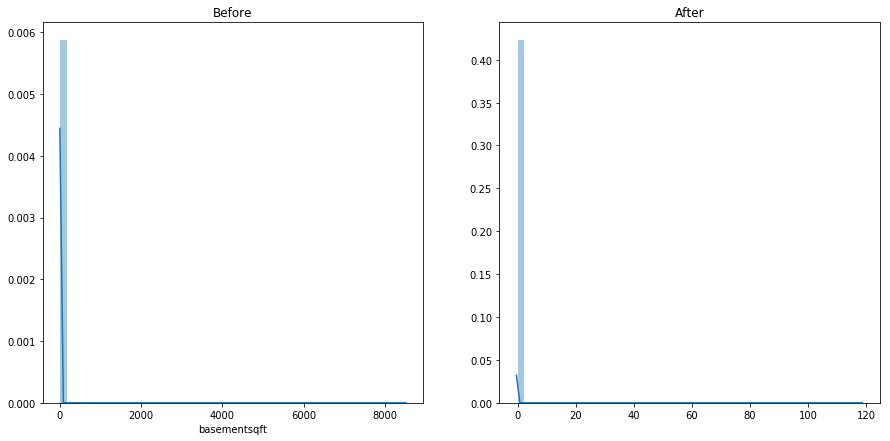

In [42]:
#assert data['garagetotalsqft'].isnull().sum() == 0

# check for outliers
f, ax = plt.subplots(nrows=1, ncols=2, figsize=[15, 7])
sns.distplot(data['basementsqft'], ax=ax[0]).set_title('Before');

max_value = data['basementsqft'].mean() + data['basementsqft'].std() * 6
data.loc[data['basementsqft'] > max_value, 'basementsqft'] = max_value

sns.distplot(data['basementsqft'].values, ax=ax[1]).set_title('After');

### Variable: bathroomcnt - Number of bathrooms in home including fractional bathrooms
Has datatype: ordinal and 0.000841 percent of values missing

We decided to replace missing values with zeros since there are only very few. 

<font color ='red'>Pending Item: For homes with high bathroom count, validate against bed room count and square footage. Maybe these are multi family units?</font>

In [43]:
print('Before', data['bathroomcnt'].unique())
data['bathroomcnt'] = data['bathroomcnt'].fillna(0).astype(np.int32)
print('After', data['bathroomcnt'].unique())

Before [  0.     2.     4.     3.     1.     2.5    3.5    5.     1.5    4.5    7.5
   5.5    6.     7.    10.     8.     9.    12.    11.     8.5    6.5   13.
   9.5   14.    20.    19.5   15.    10.5     nan  18.    16.     1.75  17.
  19.     0.5   12.5   11.5   14.5 ]
After [ 0  2  4  3  1  5  7  6 10  8  9 12 11 13 14 20 19 15 18 16 17]


<font color ='red'>To validate the bathroom and bedroom count, as part of data cleansing, we should review the counts against unitcnt and calcualtedfinishedsquarefeet. The table below shows a 1245 sqft home with 12 bathrooms, 3 bedrooms, and 13 units. </font>

In [44]:
data['bathroomcnt'].max()

20

In [45]:
data_temp = data.query('bathroomcnt > 10') 
data_temp[['bathroomcnt','bedroomcnt','unitcnt','calculatedfinishedsquarefeet']]

,bathroomcnt,bedroomcnt,unitcnt,calculatedfinishedsquarefeet
2233,12,3.0,13.0,1245.0
4594,11,7.0,1.0,8272.0
4608,11,7.0,1.0,11810.0
5514,12,12.0,4.0,4784.0
7296,12,12.0,4.0,6220.0
7458,12,12.0,4.0,5474.0
7570,12,12.0,4.0,4784.0
19348,13,5.0,1.0,19335.0
29381,14,14.0,4.0,6064.0
34185,11,8.0,1.0,10352.0


### Variable: bedroomcnt - Number of bedrooms in home
Has datatype: ordinal and 0.000437 percent of values missing

We decided to replace missing values with zeros since there are only very few. 

<font color ='red'>Pending Item: For homes with high bathroom count, validate against bed room count and square footage. Maybe these are multi family units?</font>

In [46]:
print('Before', data['bedroomcnt'].unique())
data['bedroomcnt'] = data['bedroomcnt'].fillna(0).astype(np.int32)
print('After', data['bedroomcnt'].unique())

Before [  0.   4.   5.   2.   3.   1.   6.   7.   8.  12.  11.   9.  10.  14.  16.
  13.  nan  15.  17.  18.  20.  19.]
After [ 0  4  5  2  3  1  6  7  8 12 11  9 10 14 16 13 15 17 18 20 19]


### Variable: buildingqualitytypeid - Overall assessment of condition of the building from best (lowest) to worst (highest)
Has datatype: ordinal and 99.576949 percent of values missing

With this much missing values and the difficulty of estimating property condition, we deceided to remove this variable.

<font color ='red'>Pending Item: Variable deletion is commented, need to finalize deletion.</font>

In [47]:
#del data['buildingqualitytypeid']

### Variable: buildingclasstypeid - The building framing type (steel frame, wood frame, concrete/brick)
Has datatype: nominal and 99.576949 percent of values missing

With this much missing values and the difficulty of assigning a building framing type, we deceided to remove this variable.

<font color ='red'>Pending Item: Variable deletion is commented, need to finalize deletion.</font>

In [48]:
#del data['buildingclasstypeid']

### Variable: calculatedbathnbr - Number of bathrooms in home including fractional bathroom
Has datatype: nominal and 4.318346 percent of values missing

With a low number of missing values, we decided to assign 1 to all missing values since each property should have at least 1 bathroom.

In [49]:
print('Before', data['calculatedbathnbr'].unique())
data['calculatedbathnbr'] = data['calculatedbathnbr'].fillna(1).astype(np.int32)
print('After', data['calculatedbathnbr'].unique())

Before [  nan   2.    4.    3.    1.    2.5   3.5   5.    1.5   4.5   7.5   5.5
   6.    7.   10.    8.    9.   12.   11.    8.5   6.5  13.    9.5  14.
  20.   19.5  15.   10.5  18.   16.   17.   19.   12.5  11.5  14.5]
After [ 1  2  4  3  5  7  6 10  8  9 12 11 13 14 20 19 15 18 16 17]


### Variable: decktypeid - Type of deck (if any) present on parcel
Has datatype: nominal and 99.427311 percent of values missing

Missing values is most likely an indication of an absence of this feature in the property. Based on this, we decided to impute zeros to missing values.

In [50]:
print('Before', data['decktypeid'].unique())
data['decktypeid'] = data['decktypeid'].fillna(0).astype(np.int32)
print('After', data['decktypeid'].unique())

Before [ nan  66.]
After [ 0 66]


### Missing Values

Several missing values were found which show up as NaN in the dataframe. 

In [15]:
# Impute NaN ordinal values with 0
df[['parcelid','airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                    'buildingqualitytypeid','calculatedbathnbr','decktypeid','fips','fireplacecnt',
                    'fullbathcnt','garagecarcnt','garagetotalsqft','hashottuborspa','heatingorsystemtypeid',
                    'latitude','longitude','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7',
                    'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                    'regionidneighborhood','regionidzip','roomcnt','storytypeid','threequarterbathnbr',
                    'typeconstructiontypeid','unitcnt','yardbuildingsqft17','yearbuilt','numberofstories',
                    'fireplaceflag','structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear',
                    'landtaxvaluedollarcnt','taxamount','taxdelinquencyyear','censustractandblock']] = df[['parcelid','airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                    'buildingqualitytypeid','calculatedbathnbr','decktypeid','fips','fireplacecnt',
                    'fullbathcnt','garagecarcnt','garagetotalsqft','hashottuborspa','heatingorsystemtypeid',
                    'latitude','longitude','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7',
                    'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                    'regionidneighborhood','regionidzip','roomcnt','storytypeid','threequarterbathnbr',
                    'typeconstructiontypeid','unitcnt','yardbuildingsqft17','yearbuilt','numberofstories',
                    'fireplaceflag','structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear',
                    'landtaxvaluedollarcnt','taxamount','taxdelinquencyyear','censustractandblock']].fillna(value=0)
# df_imputed = df.fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

### Modify Data Types

Once missing values were imputed with zeros, data types can be set appropriately.

In [26]:
# replace missing values with -1
df = df.replace(to_replace='?',value=-1)

# format continuous variables
continuous_features = ['basementsqft','bathroomcnt','bedroomcnt','finishedfloor1squarefeet',
                       'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
                       'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','lotsizesquarefeet',
                       'poolsizesum']

# format ordinal/integer variables
# includes integers that are categorical
ordinal_features = ['parcelid','airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                    'buildingqualitytypeid','calculatedbathnbr','decktypeid','fips','fireplacecnt',
                    'fullbathcnt','garagecarcnt','garagetotalsqft','hashottuborspa','heatingorsystemtypeid',
                    'latitude','longitude','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7',
                    'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                    'regionidneighborhood','regionidzip','roomcnt','storytypeid','threequarterbathnbr',
                    'typeconstructiontypeid','unitcnt','yardbuildingsqft17','yearbuilt','numberofstories',
                    'fireplaceflag','structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear',
                    'landtaxvaluedollarcnt','taxamount','taxdelinquencyyear','censustractandblock']

# format string variables
string_features = ['propertycountylandusecode','propertyzoningdesc','taxdelinquencyflag']

#df[continuous_features] = [continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
#df[string_features] = df[string_features].astype(str)

# After imputation and modifiying data types, view of new data info and preliminary statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           int64
architecturalstyletypeid        int64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             int64
buildingqualitytypeid           int64
calculatedbathnbr               int64
decktypeid                      int64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            int64
fireplacecnt                    int64
fullbathcnt                     int64
garagecarcnt                    int64
garagetotalsqft                 int64
hashottuborspa                 

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,2.985217e+06,2.985217e+06,2.985217e+06,1628.000000,2.973755e+06,2.973767e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,...,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06,2.985217e+06
mean,1.332586e+07,5.249796e-01,1.462373e-02,646.883292,2.209143e+00,3.088949e+00,1.576267e-02,3.756424e+00,2.148178e+00,3.779745e-01,...,1.924829e+03,3.202096e-01,1.729523e-03,1.677362e+05,4.144857e+05,2.007278e+03,2.467494e+05,5.320825e+03,2.627685e-01,5.896216e+13
std,7.909966e+06,1.852887e+00,3.422926e-01,538.793473,1.077754e+00,1.275859e+00,2.440230e-01,3.120234e+00,1.073639e+00,4.980307e+00,...,2.764763e+02,6.423593e-01,4.155156e-02,3.990106e+05,7.228719e+05,1.244937e+02,4.415392e+05,9.151294e+03,1.925471e+00,9.479036e+12
min,1.071172e+07,0.000000e+00,0.000000e+00,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,1.164371e+07,0.000000e+00,0.000000e+00,272.000000,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,...,1.950000e+03,0.000000e+00,0.000000e+00,7.216500e+04,1.738980e+05,2.015000e+03,6.821400e+04,2.409000e+03,0.000000e+00,6.037301e+13
50%,1.254509e+07,0.000000e+00,0.000000e+00,534.000000,2.000000e+00,3.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,0.000000e+00,...,1.963000e+03,0.000000e+00,0.000000e+00,1.205040e+05,3.018630e+05,2.015000e+03,1.624370e+05,3.956000e+03,0.000000e+00,6.037555e+13
75%,1.409712e+07,1.000000e+00,0.000000e+00,847.250000,3.000000e+00,4.000000e+00,0.000000e+00,7.000000e+00,3.000000e+00,0.000000e+00,...,1.981000e+03,0.000000e+00,0.000000e+00,1.947780e+05,4.840000e+05,2.015000e+03,3.022000e+05,6.166000e+03,0.000000e+00,6.059042e+13
max,1.696019e+08,1.300000e+01,2.700000e+01,8516.000000,2.000000e+01,2.000000e+01,5.000000e+00,1.200000e+01,2.000000e+01,6.600000e+01,...,2.015000e+03,4.100000e+01,1.000000e+00,2.514860e+08,2.827860e+08,2.016000e+03,9.024622e+07,3.458861e+06,9.900000e+01,4.830301e+14


# Simple Statistics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 
</i>

<b>Answer:</b><br/>
...

In [16]:
# code here

# Visualize Attributes
<b>15 points</b>

<i>
<b>Description:</b><br/>
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.
</i>

<b>Answer:</b><br/>
...

In [17]:
# code here

# Explore Joint Attributes
<b>15 points</b>

<i>
<b>Description:</b><br/>
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.
</i>

<b>Answer:</b><br/>
...

In [18]:
# code here

# Explore Attributes and Class
<b>10 points</b>

<i>
<b>Description:</b><br/>
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).
</i>

<b>Answer:</b><br/>
...

In [19]:
# code here

# New Features
<b>5 points</b>

<i>
<b>Description:</b><br/>
Are there other features that could be added to the data or created from existing features? Which ones?
</i>

<b>Answer:</b><br/>
...

In [20]:
# code here

# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.
</i>

<b>Answer:</b><br/>
...

In [21]:
# code here